In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from utils.mask_extract import extract_masks


In [ ]:
masks = ['/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_40_mask.nii.gz',
         '/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_41_mask.nii.gz',
         '/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_42_mask.nii.gz']
labels = [2,4]


In [2]:
masks_ = ['/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_40_mask.nii.gz']
labels_ = [1,3]

In [3]:
extract_masks(masks_, labels_)

The new mask is saved as '/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_40_mask_3_1.nii.gz'.


In [28]:
fix_img = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_42_image.nii.gz', sitk.sitkFloat32)



In [29]:
fix_mask = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_42_mask.nii.gz', sitk.sitkFloat32)
mask_4_2 = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_42_mask_4_2.nii.gz', sitk.sitkFloat32)
mask_data = sitk.GetArrayFromImage(fix_mask)
mask_4_2_data = sitk.GetArrayFromImage(mask_4_2)

In [30]:
fix_data = sitk.GetArrayFromImage(fix_img)


Text(0.5, 1.0, 'Reference image and moving image')

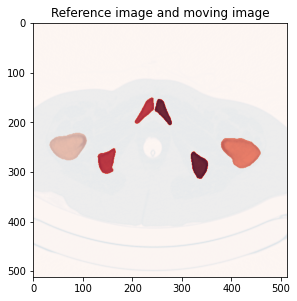

In [31]:
idx = 30
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(fix_data[idx], cmap='Blues') # fixed image
plt.imshow(mask_data[idx], cmap = 'Reds', alpha = 0.8)
plt.title('Reference image and moving image')

Text(0.5, 1.0, 'Reference image and moving image')

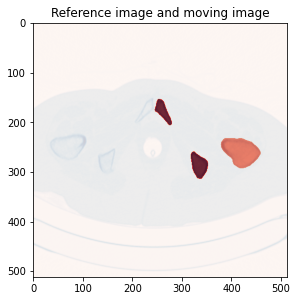

In [32]:
idx = 30
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(fix_data[idx], cmap='Blues') # fixed image
plt.imshow(mask_4_2_data[idx], cmap = 'Reds', alpha = 0.8)
plt.title('Reference image and moving image')